# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path = '/content/drive/My Drive/Greatlearning_AIML/Greatlakes/Residency_Labs_Solution/External/Residency9/'

In [12]:
import time
t_start = time.time()

version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5.model
Unet_resnet_v5.csv


### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
!mkdir train


In [0]:
!mkdir test

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

['.config', 'drive', 'train', 'test', 'sample_data']

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
os.listdir() 

In [0]:
from PIL import Image
import glob
imagelist = []
for filename in glob.glob('/content/train/images/*.png'): #assuming png
    im=Image.open(filename)
    imagelist.append(im)

In [0]:
masklist = []
for filename in glob.glob('/content/train/masks/*.png'): #assuming png
    im=Image.open(filename)
    masklist.append(im)

In [15]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=101x101 at 0x7F3B48324C88>
<PIL.PngImagePlugin.PngImageFile image mode=I size=101x101 at 0x7F3B47B71F98>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=101x101 at 0x7F3B48ABE898>
<PIL.PngImagePlugin.PngImageFile image mode=L size=101x101 at 0x7F3B482CB2E8>


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


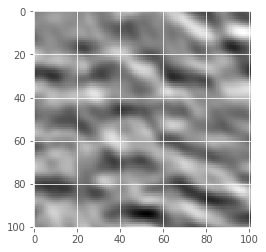

In [16]:
import matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('/content/train/images/000e218f21.png'))



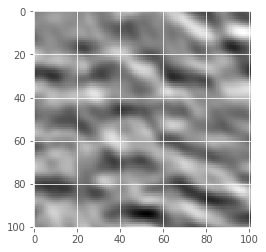

In [17]:
plt.imshow(cv2.imread('/content/train/images/000e218f21.png'))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path = '/content/train/images/' 
        ##Add mask_path
        mask_path = '/content/train/masks/'                                                           
        
        # Load images and resize to (128,128,1)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
        
        # Load masks and resize to (128,128,1)
        /*** Add your code here***/
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data()

In [21]:
def get_data(path, train=True):
  ids = next(os.walk("/content/train/images/"))[2]
  X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
  if train:
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
 
  print('Resizing image')
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    img = load_img('/content/train/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize( x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    if train:
      mask = img_to_array(load_img('/content/train/masks/' + id_, grayscale=True))
      mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
      
    X[n, ..., 0] = x_img.squeeze()/255
    
    if train:
      y[n] = mask/255
  
  print('Done')
  
  if train:
    return X, y
  else:
    return X
  
X, y = get_data(path_train, train=True)

Resizing image


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

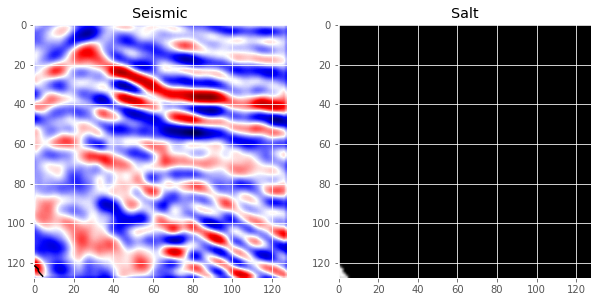

In [23]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




In [0]:
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model, load_model
import tensorflow as tf

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=1, dropout=0.5, batchnorm=True):
  
  #Contraction
  c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p1 = MaxPooling2D(pool_size=(2,2)) (c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv2d_block(p1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p2 = MaxPooling2D(pool_size=(2,2)) (c2)
  p2 = Dropout(dropout)(p2)
  
  c3 = conv2d_block(p2, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p3 = MaxPooling2D(pool_size=(2,2)) (c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
  p4 = MaxPooling2D(pool_size=(2,2)) (c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
  
  # expansion
  u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

  u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

  u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

  u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [27]:
input_img = Input((im_height, im_width, 1), name='img')

W0904 08:55:48.338365 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [30]:
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

W0904 08:56:16.798660 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 08:56:16.802633 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0904 08:56:16.858331 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 08:56:16.859820 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0904 08:56:20.442730

### 8. Define loss and dice_coeff function.

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [26]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-hkst1sqr
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-hkst1sqr
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.0b1-cp36-none-any.whl size=33612 sha256=df595105efbae6f8f862149c5583e5f0156d95db8ec605955b57ed2bf83fdb8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxnw696g/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19955 sha256=cc0d239282c2700586dafb1b32be6f451443111b343791d52a0742cfc4b72280
  Stored in directory: /root/.cache/pip/wheels/a4/22/b6/715c09496e4a64024b00a695e07a2b5804286f4840852fbcd3
  Created wheel for efficientnet: filename=efficientnet-1.0.0b3-cp36-none-any.whl size=13401 sha256=68abf8a83593800f080f7f29c431aa9597e1312a83dc74c6fc722cdcb079

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.



In [0]:
#Get the summary of your model


In [31]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

W0904 08:56:41.872299 139894363895680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 08:56:41.890421 139894363895680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(project_path + 'model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [34]:
results = model.fit(X_train, y_train, batch_size=32, epochs=1, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 35s 10ms/step - loss: 0.4270 - acc: 0.8147 - val_loss: 0.3907 - val_acc: 0.8574

Epoch 00001: val_loss improved from inf to 0.39065, saving model to /content/drive/My Drive/Greatlearning_AIML/Greatlakes/Residency_Labs_Solution/External/Residency9/model-tgs-salt.h5


In [0]:
# Load best model
model.load_weights(project_path + 'model-tgs-salt.h5')

In [37]:
# Evaluate on validation set
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 1s 2ms/step


[0.39065333048502604, 0.8574264534314473]

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [38]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 1s 2ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

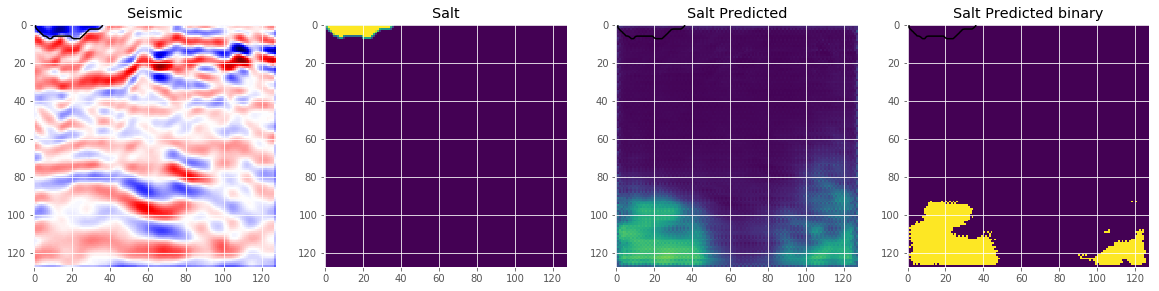

In [41]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

### Import Keras and other libraries

In [0]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_vector_length = 32

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

### Read the data

Read contents of every file from the list and append the text in a new list

## Process the text
Initialize and fit the tokenizer

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

Get the word count for every word and also get the total number of words.

Convert text to sequence of numbers

### Generate Features and Labels

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

This is just to check the features and labels

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

### Save Model

## If you have already trained the model and saved it, you can load a pretrained model

### Note: After loading the model run  model.fit()  to continue training form there, if required.

## Evaluation

## Generate text

## Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

#### Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Load the  data file

In [0]:

df = pd.read_csv('/content/drive/My Drive/Greatlearning_AIML/Greatlakes/Residency_Labs_Solution/Internal/daily-minimum-temperatures-in-me.csv', index_col='Date')

In [44]:
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### Plot the data

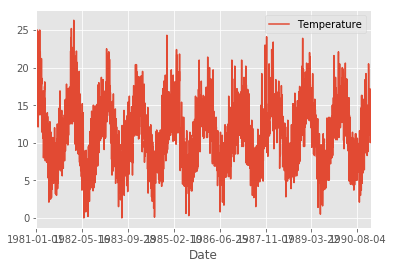

In [45]:
df.plot()

### Check for null values and treat them

In [46]:
df.describe

<bound method NDFrame.describe of             Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8
1981-01-06         15.8
1981-01-07         15.8
1981-01-08         17.4
1981-01-09         21.8
1981-01-10         20.0
1981-01-11         16.2
1981-01-12         13.3
1981-01-13         16.7
1981-01-14         21.5
1981-01-15         25.0
1981-01-16         20.7
1981-01-17         20.6
1981-01-18         24.8
1981-01-19         17.7
1981-01-20         15.5
1981-01-21         18.2
1981-01-22         12.1
1981-01-23         14.4
1981-01-24         16.0
1981-01-25         16.5
1981-01-26         18.7
1981-01-27         19.4
1981-01-28         17.2
1981-01-29         15.5
1981-01-30         15.1
...                 ...
1990-12-02         13.2
1990-12-03         16.2
1990-12-04         17.3
1990-12-05         20.5
1990-12-06         20.2
1990-12-07         19.4
1990-12-08         15.5
1990-1

In [47]:
df.isnull().sum()
#None

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
df.dropna(inplace=True)

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3aec249fd0>]],
      dtype=object)

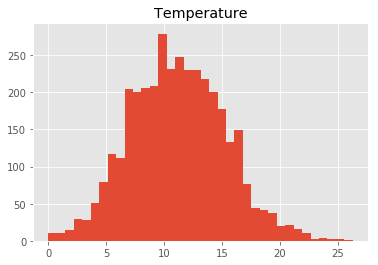

In [49]:
df.hist(bins='auto')

### Check the maximum and minimum values

In [50]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')

### Check the maximum and minimum values of scaled data

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [53]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

In [55]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [57]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [58]:
X_train[:3], y_train[:3]

(array([[0.7870723 ],
        [0.68060837],
        [0.71482889]]), array([0.68060837, 0.71482889, 0.55513311]))

In [59]:
X_test[:3], y_test[:3]

(array([[0.58174907],
        [0.54372626],
        [0.513308  ]]), array([0.54372626, 0.513308  , 0.57034222]))

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model for 100 epochs with batch size = 1

In [63]:
# The network is trained for 100 epochs and a batch size of 1 is used.
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/10
 - 17s - loss: 0.0253
Epoch 2/10
 - 15s - loss: 0.0147
Epoch 3/10
 - 15s - loss: 0.0127
Epoch 4/10
 - 15s - loss: 0.0117
Epoch 5/10
 - 16s - loss: 0.0114
Epoch 6/10
 - 16s - loss: 0.0110
Epoch 7/10
 - 15s - loss: 0.0106
Epoch 8/10
 - 15s - loss: 0.0106
Epoch 9/10
 - 16s - loss: 0.0105
Epoch 10/10
 - 16s - loss: 0.0103


### Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))